# Basically a playground of trying out new ideas
Ideas: 
- visualize output of a convolution as a changing heatmap? 
- figure out why a lot of these relational values decrease with training
- could honestly look at something like silhoutte once project w/TSNE since it's a measure of overlap more than anythign? 
- check out the relational metrics when clustering/projecting the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.cluster
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
weights_e0_l1 = np.load("layer1_epoch_0.npy")
weights_e1_l1 = np.load("layer1_epoch_1.npy")
weights_e2_l1 = np.load("layer1_epoch_2.npy")
weights_e3_l1 = np.load("layer1_epoch_3.npy")
weights_all_l1 = [weights_e0_l1, weights_e1_l1, weights_e2_l1, weights_e3_l1]
#weights_e4 = np.load("layer1_epoch_4.npy")

In [3]:
weights_e0_l2 = np.load("layer2_epoch_0.npy")
weights_e1_l2 = np.load("layer2_epoch_1.npy")
weights_e2_l2 = np.load("layer2_epoch_2.npy")
weights_e3_l2 = np.load("layer2_epoch_3.npy")
weights_all_l2 = [weights_e0_l2, weights_e1_l2, weights_e2_l2, weights_e3_l2]
#weights_e4 = np.load("layer1_epoch_4.npy")

In [4]:
from tensorflow import keras
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images,
                               test_labels) = fashion_mnist.load_data()

train_images = train_images.reshape(-1, 784)
test_images = test_images.reshape(-1, 784)

/home/linneamay/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## How do the principal components vary throughout training?

In [5]:
from sklearn.decomposition import PCA
label_c = np.array([i for i in range(10)])
pca = PCA()

### Layer 1: 500 neurons, first dense layer

0.24385102


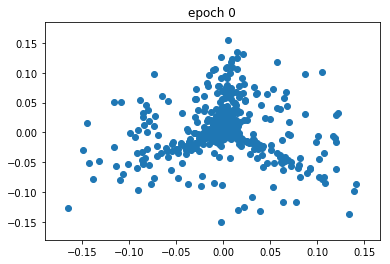

0.18596286


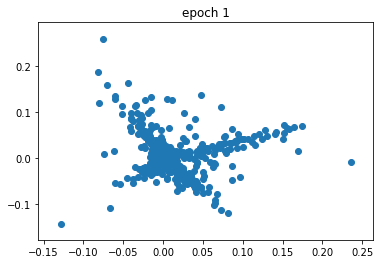

0.17793147


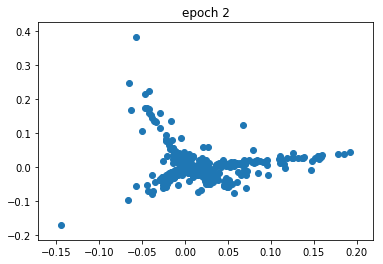

0.21546018


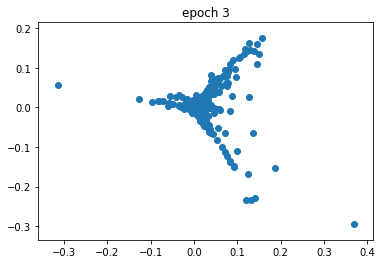

In [6]:
i = 0 
first_comp_ratios_l1 = []
for weight in weights_all_l1: 
    comps = pca.fit(weight)
    first_comp_ratios_l1.append(comps.explained_variance_ratio_[0])
    print(comps.explained_variance_ratio_[0])
    plt.title("epoch " +str(i))
    plt.scatter(x=comps.components_[1],y=comps.components_[2])
    plt.show()
    i+=1

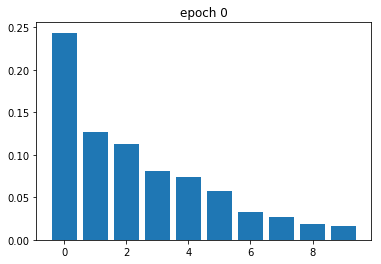

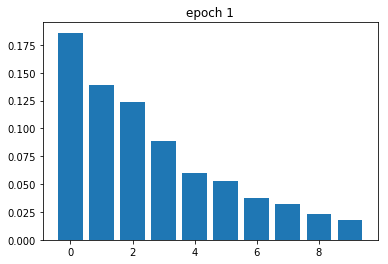

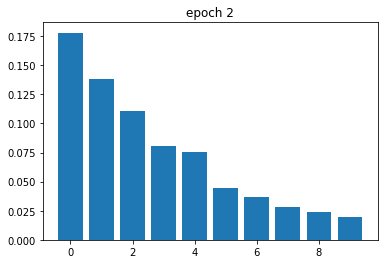

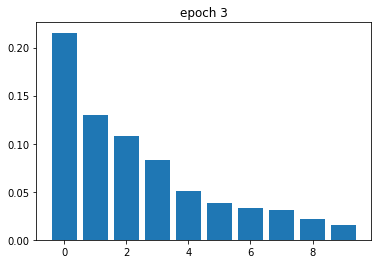

In [7]:
#TODO: show the distribution of PC's across an epoch
i = 0 
for weight in weights_all_l1: 
    comps = pca.fit(weight)
    plt.title("epoch " +str(i))
    plt.bar([i for i in range(10)],comps.explained_variance_ratio_[:10])
    plt.show()
    i+=1

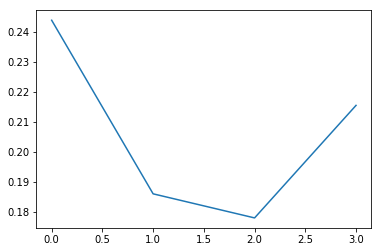

In [8]:
# How much does the first PC explain across all the epochs? 
plt.plot(first_comp_ratios_l1)

Looking at the graphs in the cell above, this evolution makes sense. The final scatterplot of the first 2 PC's look like more disctinct components can draw from. 

Why is it that the 1st PC starts to be the dominant one again? Maybe take a look at the train/test accuracy across those epochs, maybe can see that overfitting. 

#### Variance across the epochs
It makes sense that variance is increasing. As the model learns to differentiate the inputs, activations will vary more and more to distinguish them. 

In [9]:
"""
    Given an [#epochs, #neurons, #inputs] matrix, creates an array of variance for each epoch. 
"""
def calc_varaiance_across_epochs(all_weights): 
    variances = np.array([])
    for w in all_weights: 
       #print(np.var(w))
        variances = np.append(variances, (np.var(w)))
    
    return variances

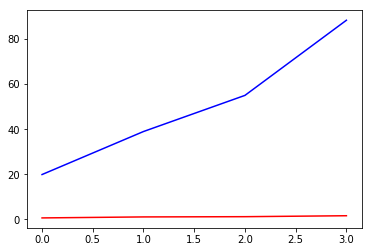

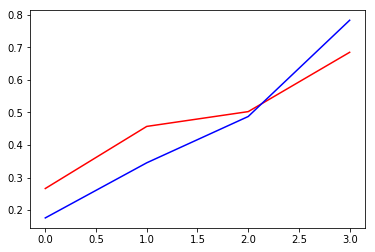

In [10]:
plt.plot(calc_varaiance_across_epochs(weights_all_l1), c='red')
plt.plot(calc_varaiance_across_epochs(weights_all_l2), c='blue')
plt.show()

v1 = calc_varaiance_across_epochs(weights_all_l1) 
v1/=np.sqrt(np.sum(v1**2))
v2 = calc_varaiance_across_epochs(weights_all_l2) / np.sqrt(np.sum(v1**2))
v2 /= np.sqrt(np.sum(v2**2))
plt.plot(v1, c='red')
plt.plot(v2, c='blue')
plt.show()

### Layer 2: 10 neurons, last dense layer

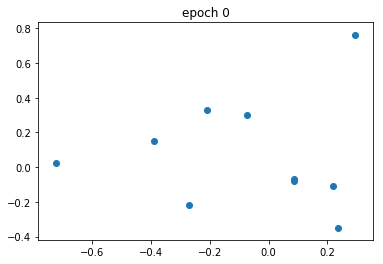

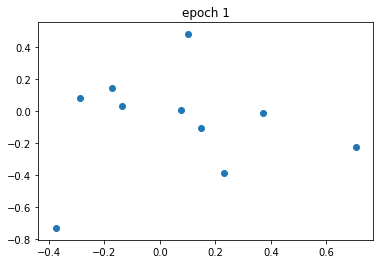

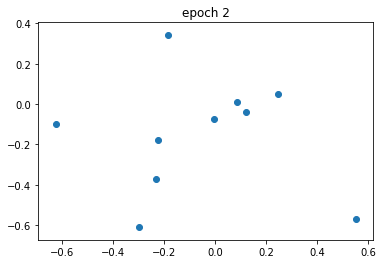

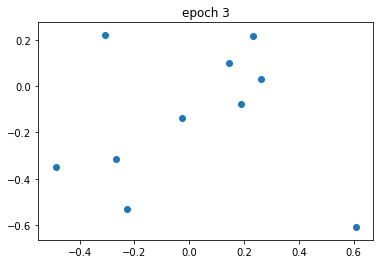

In [11]:
i = 0 
first_comp_ratios = []
for weight in weights_all_l2: 
    comps = pca.fit(weight)
    first_comp_ratios.append(comps.explained_variance_ratio_[0])
    plt.title("epoch " +str(i))
    plt.scatter(x=comps.components_[1],y=comps.components_[2])
    plt.show()
    i+=1

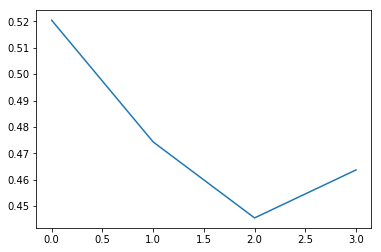

In [12]:
# How much does the first PC explain across all the epochs? 
plt.plot(first_comp_ratios)

## Wassup with Clustering

In [13]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=3, min_samples=2).fit(weights_e0_l1)
clustering.labels_[:5]

array([-1, -1, -1, -1, -1])

In [14]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
for i in weights_all_l1: 
    clustering = KMeans( n_clusters=10).fit(i)
    print(silhouette_score(weights_e0_l1, clustering.labels_)) 

/home/linneamay/anaconda3/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


0.3076962
0.2859868
0.26836014
0.23989184


I mean we have the labels, we just wanna see a general overview of where they're ending up. 

### Silhouette Score
s(i) = (b(i) - a(i)) / max(a(i), b(i)). 

Where b(i) = average distance of point i to all points in nearest non-member cluster.   
      a(i) = average distance of point i to all point in the same cluster.   
      
A score close to 0 means the clusters are relatively overlapping, or b(i) = a(i). This is fine usually but likely because of curse of dimenionality, these values are roughly equal when you wouldn't expect them to be. 

The values seem to be getting closer to 0, which means the distance within a cluster is increasing, supposedly more than the distance between clusters. 

Since the variance does seem to increase those, I suppose that means that this makes sense. Maybe if the clusterings get too far apart, that might mean overfitting? 

In [ ]:
print("Silhoutte scores for layer 1 ")
for i in range(len(weights_all_l1)):
    print("Epoch ", i, ": ", silhouette_score(weights_all_l1[i], test_labels[:500]))
#silhouette_score(weights_e0_l1, test_labels[:500])

In [ ]:
print("Silhoutte scores for layer 2 ")
for i in range(len(weights_all_l2)):
    print("Epoch ", i, ": ", silhouette_score(weights_all_l2[i], test_labels[:500]))
#silhouette_score(weights_e0_l1, test_labels[:500])

In [ ]:
print(silhouette_score(weights_e0_l1, test_labels[:500]))
print(silhouette_score(weights_e1_l1, test_labels[:500]))
print(silhouette_score(weights_e2_l1, test_labels[:500]))

Things to try: 
    - Precompute with silhouette: cosine, pearson
    - Create similarity matrix and use MDS to project into 2D

### Silhouette Score with Cosine Similarity
The values don't seem to be changing too much to be significant, or are even still decreasing. 

In [ ]:
print(silhouette_score(weights_all_l1[0], test_labels[:500], metric="cosine"))
print(silhouette_score(weights_all_l1[1], test_labels[:500], metric="cosine"))
print(silhouette_score(weights_all_l1[2], test_labels[:500], metric="cosine"))
print(silhouette_score(weights_all_l1[3], test_labels[:500], metric="cosine"))

In [ ]:
print(silhouette_score(weights_all_l2[0], test_labels[:500], metric="cosine"))
print(silhouette_score(weights_all_l2[1], test_labels[:500], metric="cosine"))
print(silhouette_score(weights_all_l2[2], test_labels[:500], metric="cosine"))
print(silhouette_score(weights_all_l2[3], test_labels[:500], metric="cosine"))

### Silhouette Score with Correlation
Seem to be approximately the same as cosine, and similarly unhelpful trend/insights> 

In [ ]:
print(silhouette_score(weights_all_l1[0], test_labels[:500], metric="correlation"))
print(silhouette_score(weights_all_l1[1], test_labels[:500], metric="correlation"))
print(silhouette_score(weights_all_l1[2], test_labels[:500], metric="correlation"))
print(silhouette_score(weights_all_l1[3], test_labels[:500], metric="correlation"))

In [ ]:
print(silhouette_score(weights_all_l2[0], test_labels[:500], metric="correlation"))
print(silhouette_score(weights_all_l2[1], test_labels[:500], metric="correlation"))
print(silhouette_score(weights_all_l2[2], test_labels[:500], metric="correlation"))
print(silhouette_score(weights_all_l2[3], test_labels[:500], metric="correlation"))

## Projections based on dissimilarity

In [ ]:
""" 
    Makes an [n, n] matrix of dissimilarity scores from an [n, m] sized matrix where n samples has m features. 
    Possible metrics: 
        1. cosine (defualt): 1- cosine similarity
"""
def make_dissim_scores(samples, metric="cosine"): 
    sim_matrix = np.array([])
    if metric == "cosine": 
        sim_matrix = cosine_similarity(weights_e0_l1)
        # Some rounding errors I think, but manually set the diagonal to be 1
        # Not a great fix to the underlying issue though
        for i in range(len(sim_matrix)): 
            sim_matrix[i][i] = round(sim_matrix[i][i])
            sim_matrix[i] = (list(map(lambda x: 1-x, sim_matrix[i])))
        return sim_matrix
    #elif metric = "pearson": 

In [ ]:
sims_all_l1 = np.array(list(map(lambda x: make_dissim_scores(x), weights_all_l1)))

In [ ]:
from sklearn.manifold import MDS
mds = MDS(n_components=2, dissimilarity='precomputed')
weights_transform = mds.fit_transform(sims_all_l1[0])

In [ ]:
weights_transform.shape

In [ ]:
for i in sims_all_l1:
    weights_transform=mds.fit_transform(i)
    plt.scatter(weights_transform[:,0], weights_transform[:,1], c=test_labels[:500])
    plt.show()

In [ ]:
mds = MDS(n_components=2, dissimilarity='cosine')

for i in weights_all_l1:
    weights_transform=mds.fit_transform(i)
    plt.scatter(weights_transform[:,0], weights_transform[:,1], c=test_labels[:500])
    plt.show()

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(perplexity=90, n_components=2, init='random', n_iter=5000)
lowD_1 = tsne.fit_transform(sims_all_l1[0])

In [ ]:
plt.scatter(lowD_1[:, 0],lowD_1[:, 1], c=test_labels[:500])

In [ ]:
tsne.set_params(metric="precomputed")
lowD_1_precomputed = tsne.fit_transform(sims_all_l1[0])

In [ ]:
plt.scatter(lowD_1_precomputed[:, 0],lowD_1_precomputed[:, 1], c=test_labels[:500])

## Neighbourhood Comparison
Seems to work better for the smaller layers, so I can't imagine the conv layers getting anything any better because their size will blow up even more. 

In [ ]:
l2_e0_df = pd.DataFrame(weights_e0_l2)
l2_e0_df["cluster"] = test_labels[:500]
l2_e0_df.head()

In [ ]:
"""
    make_sim_matrix is an [n_samples, n_samples] matrix of parwise similarities. 
    X: the [n_samples, n_features] matrix from which to genarate the similarities. 
    Method: the method for computing pairwise similarities. Default is cosine. If "precomputed", returns X. 
"""
def make_sim_matrix(X, method="cosine"):
    sim_matrix = []
    
    if method == "cosine": 
        sim_matrix = np.array(cosine_similarity(X))
    elif method == "precomputed":
        sim_matrix = np.array(X)
    
    #ensure the diagonal is 1
    for i in range(len(sim_matrix)): 
        sim_matrix[i][i] = round(sim_matrix[i][i])
        #sim_matrix[i] = (list(map(lambda x: 1-x, sim_matrix[i])))
        
    return sim_matrix

In [ ]:
"""
    get_nh returns the neighborhood value of a point, ie the % of the k nearest points 

"""
def get_nh(sim_matrix, feature_matrix, row_index, k=5):
    row = feature_matrix.iloc[row_index, :]
    # Remove any of the diagonal values
    filtered = list(filter(lambda x: x!=1, sim_matrix[row_index]))
    #Get the top k neighbors
    top = np.sort(filtered)[-k:]
    #print(top)
    clusters = []
    for i in range(len(sim_matrix[row_index])): 
        if sim_matrix[row_index][i] in top: 
            #rint(l2_e1_df.iloc[i, 10])
            clusters.append(feature_matrix.iloc[i, -1])
    #print(clusters)
    # Get the cluster of the original vector
    i_cluster = row[-1]
    #print(row)
    # Get the proprotion of the neighbors that are in the same cluster. 
    return len(list(filter(lambda x: x== i_cluster, clusters))) / len(clusters)

def average_nh(feature_matrix):
    sim_matrix = make_sim_matrix(feature_matrix.iloc[:, :10].values)
    avg = 0
    for i in range(len(feature_matrix)):
        avg += get_nh(sim_matrix, feature_matrix, i)
    return avg / len(feature_matrix)

In [ ]:
get_nh(l2_e0_sim, l2_e0_df, 0)

In [ ]:
average_nh(l2_e0_df)

In [ ]:
for epoch in weights_all_l2: 
    df_i = pd.DataFrame(epoch)
    df_i['cluster'] = test_labels[:500]
    print(average_nh(df_i))

In [ ]:
for epoch in weights_all_l1: 
    df_i = pd.DataFrame(epoch)
    df_i['cluster'] = test_labels[:500]
    print(average_nh(df_i))